[*********************100%***********************]  1 of 1 completed


Epoch [1/50], Loss: 0.0013
Epoch [2/50], Loss: 0.0001
Epoch [3/50], Loss: 0.0001
Epoch [4/50], Loss: 0.0001
Epoch [5/50], Loss: 0.0001
Epoch [6/50], Loss: 0.0001
Epoch [7/50], Loss: 0.0001
Epoch [8/50], Loss: 0.0001
Epoch [9/50], Loss: 0.0001
Epoch [10/50], Loss: 0.0001
Epoch [11/50], Loss: 0.0001
Epoch [12/50], Loss: 0.0001
Epoch [13/50], Loss: 0.0001
Epoch [14/50], Loss: 0.0001
Epoch [15/50], Loss: 0.0001
Epoch [16/50], Loss: 0.0001
Epoch [17/50], Loss: 0.0001
Epoch [18/50], Loss: 0.0001
Epoch [19/50], Loss: 0.0001
Epoch [20/50], Loss: 0.0001
Epoch [21/50], Loss: 0.0001
Epoch [22/50], Loss: 0.0001
Epoch [23/50], Loss: 0.0001
Epoch [24/50], Loss: 0.0000
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0001
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0000
Epoch [32/50], Loss: 0.0000
Epoch [33/50], Loss: 0.0000
Epoch [34/50], Loss: 0.0000
Epoch [35/50], Loss: 0.0000
Epoch [36/50], Loss: 0.0000
E

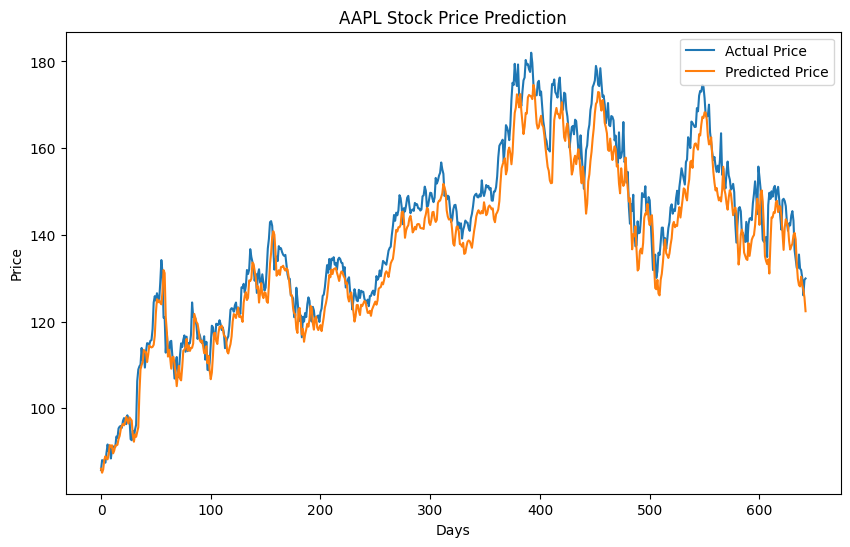

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# LSTM 모델 정의
class HedgeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(HedgeLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 마지막 출력만 사용
        return out

# 데이터셋 준비
class StockDataset(Dataset):
    def __init__(self, data, target, sequence_length=10):
        self.data = data
        self.target = target
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        seq_data = self.data[idx:idx + self.sequence_length]
        target = self.target[idx + self.sequence_length]
        return torch.tensor(seq_data, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


# 데이터 다운로드 및 준비
def load_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data[['Close']]  # 종가만 사용
    return stock_data

# 주식 데이터 다운로드
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'
stock_data = load_data(ticker, start_date, end_date)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

# 데이터 준비 (시계열 데이터)
sequence_length = 10
X = []
y = []

# X는 직전 n일간 주가, y는 그 다음날 주가
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 데이터 로더 준비
train_dataset = StockDataset(X_train, y_train, sequence_length)
test_dataset = StockDataset(X_test, y_test, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 설정
input_size = sequence_length # 직전 n일간 주가
hidden_size = 64
num_layers = 2
output_size = 1  # 종가 예측
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HedgeLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# 손실 함수와 최적화 함수
criterion = nn.MSELoss()  # MSE Loss (주식 가격 예측)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 함수
def train_model(model, train_loader, optimizer, criterion, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.unsqueeze(-1).to(device)  # 차원 맞추기

            # 예측
            predictions = model(inputs)

            # 손실 계산
            loss = criterion(predictions, targets)

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    print("Training complete")

# 모델 학습
train_model(model, train_loader, optimizer, criterion, num_epochs=50)

# 모델 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.unsqueeze(-1).to(device)  # 차원 맞추기

            # 예측
            preds = model(inputs)
            predictions.append(preds.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    return predictions, actuals

# 모델 평가
predictions, actuals = evaluate_model(model, test_loader)

# 예측 결과 시각화
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()
